In [1]:
%cd ../src
%load_ext autoreload
%autoreload 2

/home/ubuntu/SPVD_Lightning/src


In [2]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [48]:
from dataloaders.shapenet.shapenet_loader import ShapeNet

categories = ['car']
path = "../data/ShapeNet"

te = ShapeNet(path, "val", 2048, categories, load_renders=False)

Loading (val) pointclouds for car (02958343):   0%|          | 0/352 [00:00<?, ?it/s]

In [49]:
from tqdm.auto import tqdm
from metrics.rgb2point import chamfer_distance, EMDLoss

def cd_f(gen_pc, ref_pc):
    B, N, C = gen_pc.shape
    cd_mean = 0
    ref_pc = ref_pc - ref_pc.mean(dim=1, keepdim=True)
    # Point Clouds should have the max distance from the origin equal to 0.64
    r = (ref_pc * ref_pc).sum(dim=-1).sqrt().max(dim=1, keepdim=True)[0]
    #print(f'Max radius: {r.shape}')
    #print(ref_pc.shape)
    ref_pc = ref_pc / r.unsqueeze(-1) * 0.64
    # Shuffle Points in each point cloud of the batch
    ref_pc = ref_pc[:, torch.randperm(ref_pc.shape[1])]
    ref_pc = ref_pc[:, :1024] # Take only 1024 points from each point cloud

    gen_pc = gen_pc - gen_pc.mean(dim=1, keepdim=True)
    # Point Clouds should have the max distance from the origin equal to 0.64
    r = (gen_pc * gen_pc).sum(dim=-1).sqrt().max(dim=1, keepdim=True)[0]
    # print(f'Max radius: {r}')
    gen_pc = gen_pc / r.unsqueeze(-1) * 0.64
    # Shuffle Points in each point cloud of the batch
    gen_pc = gen_pc[:, torch.randperm(gen_pc.shape[1])]
    gen_pc = gen_pc[:, :1024]

    for g, r in tqdm(zip(ref_pc, gen_pc), leave=False):
        g = g.detach().cpu()
        r = r.detach().cpu()
        cd_mean += chamfer_distance(g, r, direction='bi') / 2
    
    return cd_mean / B

In [50]:
def convert_pc(pc):
    pc = pc - pc.mean(dim=1, keepdim=True)
    # Point Clouds should have the max distance from the origin equal to 0.64
    r = (pc * pc).sum(dim=-1).sqrt().max(dim=1, keepdim=True)[0]
    #print(f'Max radius: {r.shape}')
    #print(pc.shape)
    pc = pc / r.unsqueeze(-1) * 0.64
    
    pc = pc[:, torch.randperm(pc.shape[1])]
    # pc = pc[:, :1024]
    
    return pc

In [51]:
from utils.helper_functions import normalize_to_unit_sphere, standardize
from metrics.chamfer_dist import ChamferDistanceL2
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD
from tqdm import tqdm

cd = ChamferDistanceL2()
# point_clouds = normalize_to_unit_sphere(torch.stack([te[i]['pc'] for i in range(len(te))])).cuda()
point_clouds = convert_pc(torch.stack([te[i]['pc'] for i in range(len(te))])).cuda()
P = torch.randn(2048, 3, requires_grad=True, device='cuda')


for lr in (0.05, 0.02, 0.01, 0.005):
    optim = torch.optim.Adam([P], lr=lr)
    p_bar = tqdm(range(50))
    for _ in p_bar:
        loss = sum(cd(P.unsqueeze(0), pc.unsqueeze(0)) for pc in point_clouds) / len(point_clouds)
        optim.zero_grad()
        loss.backward()
        optim.step()
        p_bar.set_postfix({'loss': loss.item()})

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.57it/s, loss=0.00182]


In [52]:
from utils.visualization import display_pointclouds_grid
import numpy as np
# P = P
display_pointclouds_grid(np.array([P.detach().cpu(), point_clouds.cpu()[0]]), point_size=0.05)

Output()

0.03411854858011891


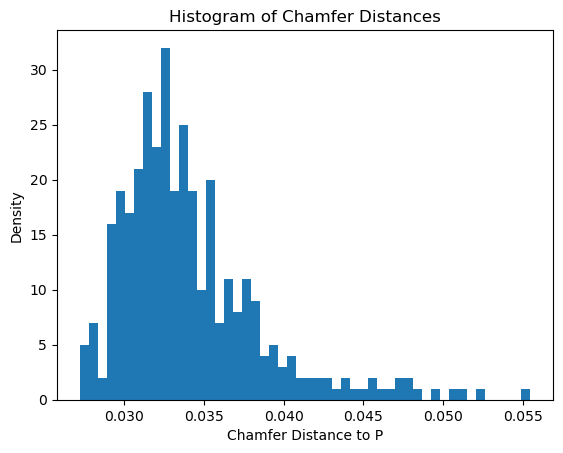

In [56]:
from scipy.stats import zscore
import numpy as np

import matplotlib.pyplot as plt

cd_values = [cd_f(P.unsqueeze(0), pc.unsqueeze(0)).item() for pc in point_clouds]
cd_values_np = np.array(cd_values)
# z_scores = zscore(cd_values_np)
# cd_values_filtered = cd_values_np[np.abs(z_scores) < 3]
# cd_values = cd_values_filtered.tolist()

print(np.mean(cd_values))

plt.hist(cd_values, bins=50)
plt.xlabel('Chamfer Distance to P')
plt.ylabel('Density')
plt.title('Histogram of Chamfer Distances')
plt.show()